In [ ]:
# sarscov2 analysis 

In [1]:
import glob
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
from utils_arcs import plot_arcs_from_list
from statannot import add_stat_annotation
import seaborn as sns

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


In [ ]:
## 1. Supp_Figure_6a_6b_6c ---  --- 

In [ ]:
## 1. Supp_Figure_6c ---  ---  

In [2]:
### A. prepare the input files 

p_gene = "EPI_ISL_407987_full_length"
p_samples = ["200922_antson_10", "201002_antson_09_2", "201002_antson_10_2"]

### get the windows and sliding 

def get_start_end_coords(p_length, p_offset=0, p_window=100, p_step_size=1):
    p_coords = [ (i, i+p_window) for i in list(range(p_offset+0, p_offset+p_length-p_window, 
                                                     p_step_size)) ]
    return p_coords

def get_sizes(f_sizes):
    sizes = {}
    with open(f_sizes, "r") as f:
        for line in f:
            row = line.strip("\r\n").split("\t")
            sizes[row[0]] = int(row[1])
    return sizes 
sizes = get_sizes('/home/ubuntu/projects/proj_het/data/sarscov2/nanopore_v2/dtw/data/reference/EPI_ISL_407987_subgenomic_t2u.sizes')


2526
2925
          corr  WT_prop  homogeneity            loci
0     0.008624   0.0110     0.978430        (0, 600)
1     0.017061   0.0195     0.962413       (10, 610)
2    -0.044612   0.0090     0.981366       (20, 620)
3    -0.054794   0.0120     0.974989       (30, 630)
4    -0.024364   0.0195     0.960829       (40, 640)
...        ...      ...          ...             ...
2521 -0.037675   0.0525     0.896764  (29200, 29800)
2522  0.149878   0.0560     0.910118  (29210, 29810)
2523 -0.040988   0.0760     0.853795  (29220, 29820)
2524  0.009886   0.0535     0.899726  (29230, 29830)
2525 -0.017475   0.0495     0.904256  (29240, 29840)

[2526 rows x 4 columns]
                loci
0           (0, 600)
1          (10, 610)
2          (20, 620)
3          (30, 630)
4          (40, 640)
...              ...
2920  (29200, 29800)
2921  (29210, 29810)
2922  (29220, 29820)
2923  (29230, 29830)
2924  (29240, 29840)

[2925 rows x 1 columns]
                loci      corr  WT_prop  homogeneity

2925
2925
2925


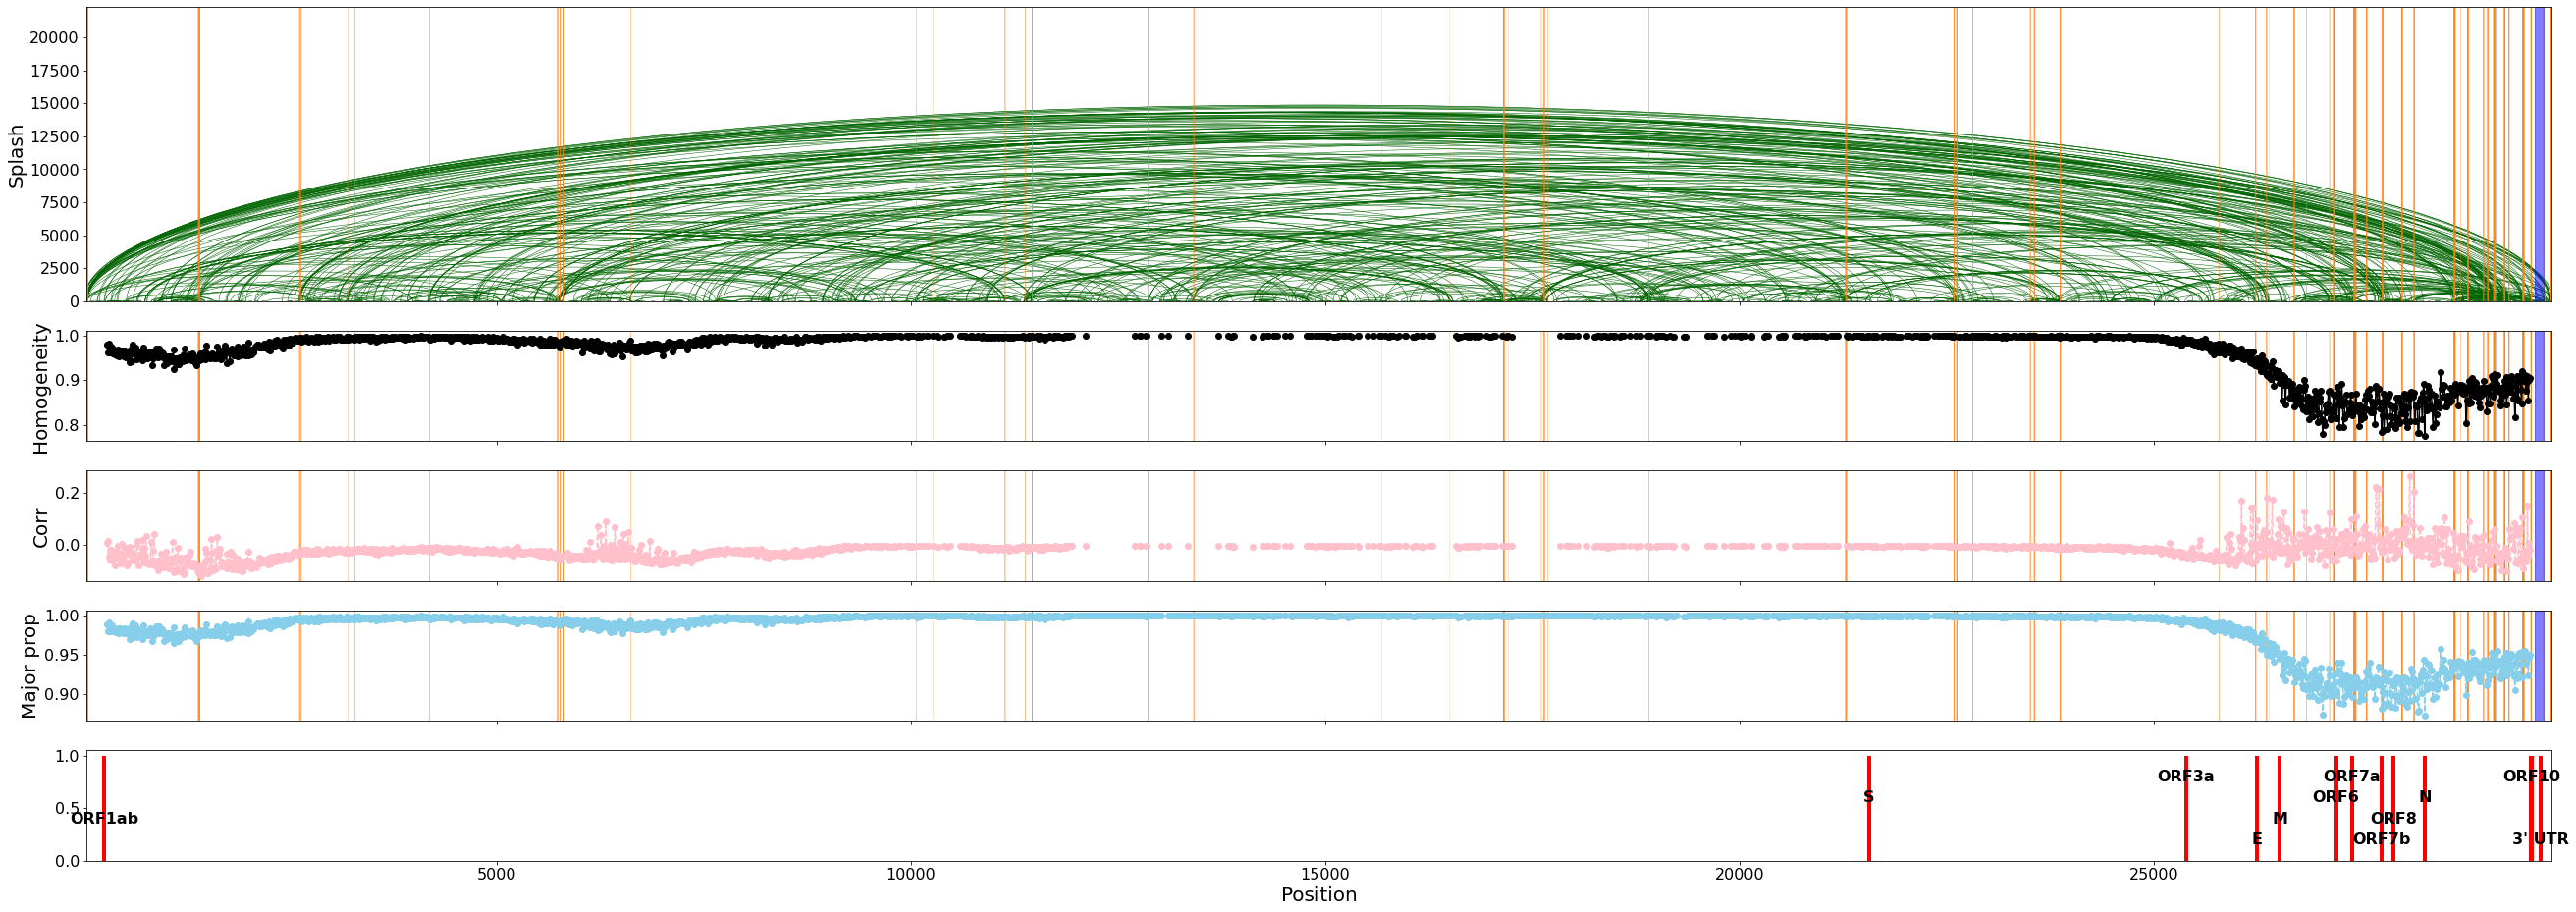

In [13]:
### to get the new list for plots

dir_out = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/"
dfall = pd.read_csv(dir_out+"sarscov2_full_length_window_homogeneiety.txt", sep='\t')
list_prop = list(dfall.WT_prop)
list_homogeneity = list(dfall.homogeneity)
list_corr = list(dfall['corr'])
print(len(list_homogeneity))

### to get the windows

windows = len(list(range(300,29550,10)))
print(windows) 

f_center = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/SARS-CoV2_SPLASH_B01.center"

p_offset = 0

def get_list_of_arcs(dotbracket, p_start, p_end):
    list_of_coords = []
    curr_list = []
    for n2, i in enumerate(dotbracket):
        if i == "(":
            curr_list.append(n2)
        elif i == ")":
            n1 = curr_list.pop(-1)
            list_of_coords.append((n1, n2))

    flt_list = []
    for s, e in list_of_coords:
        if (s >= p_start and e <= p_end):
            flt_list.append((s, e))
    return flt_list

list_of_splash = []
list_of_splash_count = []
with open(f_center, "r") as f:
    for line in f:
        row = line.strip("\r\n").split("\t")
        mid1 = (int(row[1]) + int(row[2]))//2
        mid2 = (int(row[4]) + int(row[5]))//2
        count = int(row[12].split("_")[-1])

        if (mid1 >= 0 and mid1 <= 29844) and (mid2 >= 0 and mid2 <= 29844):
            list_of_splash.append((mid1-p_offset, mid2-p_offset))
            list_of_splash_count.append(count)

p_cluster = 2

p_length = 29844


fig, ax = plt.subplots(5, 1, figsize=(45, 16), sharex=True, gridspec_kw={'height_ratios':[4,1.5,1.5,1.5,1.5]})


plot_arcs_from_list(list_of_splash, list_of_counts=list_of_splash_count, p_figax=(fig, ax[0]), p_show_count=False, p_linewidth=0.5,p_color="darkgreen")
ax[0].set_ylabel("Splash", fontsize=20)


### 2. homogeneity curve, add the correlation and proportion curve 

list_major_prop = [x if x >=0.5 else 1-x for x in list_prop]

ax[1].plot(range(300,29550,10),list_homogeneity[0:windows], linestyle='-', marker='o', color='black', label='line with marker')
ax[2].plot(range(300,29550,10),list_corr[0:windows], linestyle='--', marker='o', color='pink', label='line with marker')
ax[3].plot(range(300,29550,10),list_major_prop[0:windows], linestyle='--', marker='o', color='skyblue', label='line with marker')

ax[1].set_ylabel("Homogeneity", fontsize=20)
ax[2].set_ylabel("Corr", fontsize=20)
ax[3].set_ylabel("Major prop", fontsize=20)

### to highlight the alternative structures 
### to get the alt structures number
### Secondary Structure

p_length = 29844

dict_interval = {}
list_of_coords = []
with open(f_center, "r") as f:
    for line in f:
        row = line.strip("\r\n").split("\t")
        mid1 = int((int(row[1])+int(row[2]))/2)
        mid2 = int((int(row[4])+int(row[5]))/2)

        if (mid1 - p_offset) >= 0 and (mid2 - p_offset) >= 0:
            list_of_coords.append((mid1-p_offset, mid2-p_offset))

            for x in range(mid1-p_offset-5, mid1-p_offset+5):
                try:
                    dict_interval[x] += 1
                except KeyError:
                    dict_interval[x] = 1

            for x in range(mid2-p_offset-5, mid2-p_offset+5):
                try:
                    dict_interval[x] += 1
                except KeyError:
                    dict_interval[x] = 1


dict_interval   ### center of the clusters 


list_altstruct = []

altstruct_coords = list(np.arange(0,p_length))

for c in altstruct_coords:
    
    try:
        list_altstruct.append(dict_interval[c])
    except KeyError:
        list_altstruct.append(0)


### df
dict = {'altstruc': list_altstruct, 'coord': altstruct_coords} 
df = pd.DataFrame(dict)   
df = df.sort_values(by=['altstruc'],ascending=False)
dir_out = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/"
df.to_csv(dir_out + "sarscov2_full_length_alternative_structure.txt", sep='\t')


diff = df['altstruc'].quantile(q=0.99)
flt = df[df['altstruc'] >=diff]
hub = list(flt.coord)

### to get the alt structures number
   
for i in range(4):

    for j in hub:
        ax[i].axvspan(j,j+1,color=colors[1], alpha=0.2)
        
     
### draco regions from paper  
for i in range(4):  
    ax[i].axvspan(29600, 29700, color='blue', alpha=0.5)

### add the sarscov2 genome

roi_pos =    [0,             265,  21562,25392, 26244,26522, 27201,  27393,   27755, 27893, 28273, 29557,    29674]
roi_labels = ["5' UTR",     "ORF1ab","S","ORF3a","E",   "M",  "ORF6", "ORF7a","ORF7b","ORF8", "N",  "ORF10", "3' UTR"]

ax[4].bar(roi_pos,np.ones(len(roi_pos)),color='red',width=50)
for j in range(len(roi_pos)):
    plt.annotate(roi_labels[j],xy=(roi_pos[j],0.20+(j%4)*0.20),horizontalalignment='center',verticalalignment='center',fontsize=16,weight='bold')
ax[4].set_xlabel("Position", fontsize=20)

### change ticks 
for i in range(5):
    ax[i].tick_params(axis='both', which='major', labelsize=16) 

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/'
plt.savefig(dir_out+'Supp_Figure_6c_homogeneiety_across_whole_sarscov2.pdf',bbox_inches='tight', dpi=300) 
plt.show()  

29844
[(0, 1000), (500, 1500), (1000, 2000), (1500, 2500), (2000, 3000), (2500, 3500), (3000, 4000), (3500, 4500), (4000, 5000), (4500, 5500), (5000, 6000), (5500, 6500), (6000, 7000), (6500, 7500), (7000, 8000), (7500, 8500), (8000, 9000), (8500, 9500), (9000, 10000), (9500, 10500), (10000, 11000), (10500, 11500), (11000, 12000), (11500, 12500), (12000, 13000), (12500, 13500), (13000, 14000), (13500, 14500), (14000, 15000), (14500, 15500), (15000, 16000), (15500, 16500), (16000, 17000), (16500, 17500), (17000, 18000), (17500, 18500), (18000, 19000), (18500, 19500), (19000, 20000), (19500, 20500), (20000, 21000), (20500, 21500), (21000, 22000), (21500, 22500), (22000, 23000), (22500, 23500), (23000, 24000), (23500, 24500), (24000, 25000), (24500, 25500), (25000, 26000), (25500, 26500), (26000, 27000), (26500, 27500), (27000, 28000), (27500, 28500), (28000, 29000), (28500, 29500)]


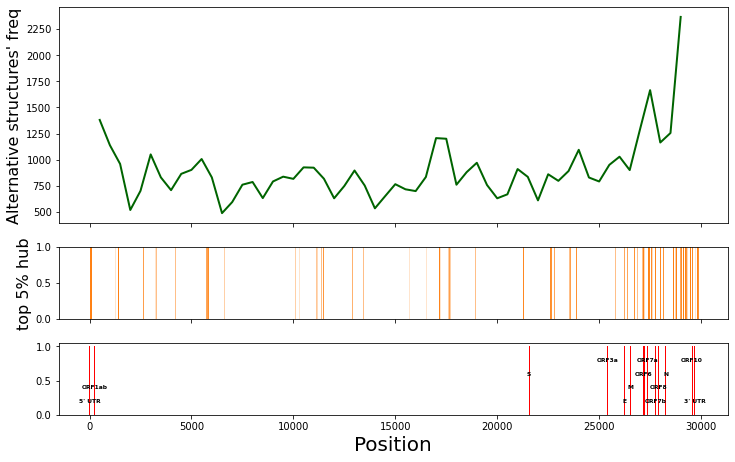

In [17]:
### plots the alternative structure counts ---

dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/'
df = pd.read_csv(dir+'alter_homo_cov2000.txt',sep='\t') 

list_of_loci = get_start_end_coords(sizes['EPI_ISL_407987_full_length'],p_offset=0, p_window=1000, p_step_size=500)
print(sizes['EPI_ISL_407987_full_length'])
print(list_of_loci)

list_s, list_e, list_count, list_pos  = [], [], [], []

for s, e in list_of_loci:

    tmp = df[(df['coord'] <e) & (df['coord'] >=s)]
    count = tmp.altstruc.sum()
    pos = (s+e)/2
    list_s.append(s)
    list_e.append(e)
    list_count.append(count)
    list_pos.append(pos)


dict = {'pos': list_pos, 'altstruc': list_count, 'start': list_s,'end': list_e} 
res = pd.DataFrame(dict)   
res = res.sort_values(by=['pos'],ascending=True)
res['pos'] = res['pos'].astype(int)


for i in range(4):

    for j in hub:
        ax[i].axvspan(j,j+1,color=colors[1], alpha=0.2)
        #ax[i].tick_params(axis='both', which='major', labelsize=12)


### plot the alterstructure ------

fig, ax = plt.subplots(3, 1, figsize=(12,7.5), sharex=True, gridspec_kw={'height_ratios':[4.5,1.5,1.5]})

ax[0].plot(res.pos, res.altstruc, linewidth = 2, alpha=1, color = 'darkgreen')
ax[0].set_ylabel("Alternative structures' freq", fontsize=16)


for j in hub:
    ax[1].axvspan(j,j+1,color=colors[1], alpha=0.2)
ax[1].set_ylabel("Alternative structures' freq", fontsize=16)
ax[1].set_ylabel("top 5% hub", fontsize=16)

roi_pos =    [0,             265,  21562,25392, 26244,26522, 27201,  27393,   27755, 27893, 28273, 29557,    29674]
roi_labels = ["5' UTR",     "ORF1ab","S","ORF3a","E",   "M",  "ORF6", "ORF7a","ORF7b","ORF8", "N",  "ORF10", "3' UTR"]
ax[2].bar(roi_pos,np.ones(len(roi_pos)),color='red',width=50)
for j in range(len(roi_pos)):
    plt.annotate(roi_labels[j],xy=(roi_pos[j],0.20+(j%4)*0.20),horizontalalignment='center',verticalalignment='center',fontsize=6,weight='bold')
ax[2].set_xlabel("Position", fontsize=20)

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/'
plt.savefig(dir_out+'Supp_Figure_6c_homogeneiety_and_alterstructures.pdf',bbox_inches='tight', dpi=300) 

In [ ]:
## supp_Figure_6a  --- ---

In [19]:
dir_out = "/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/"
dfall = pd.read_csv(dir_out+"sarscov2_full_length_window_homogeneiety.txt", sep='\t')
list_prop = list(dfall.WT_prop)
list_homogeneity = list(dfall.homogeneity)
list_corr = list(dfall['corr'])
print(len(list_homogeneity))
print(len(list_of_loci))

2925
58


6.0
(29405, 6)
(439, 6)


/tmp/ipykernel_18964/2678432041.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flt['type'] = 'hub'
/tmp/ipykernel_18964/2678432041.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noflt['type'] = 'nohub'


nohub v.s. hub: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.973e-65 U_stat=5.993e+06


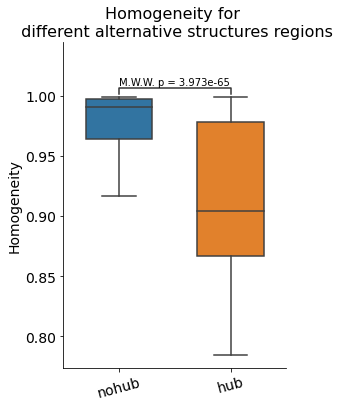

In [24]:
### A. prepare profiles 

diff = df['altstruc'].quantile(q=0.99)
print(diff)
diff = df['altstruc'].quantile(q=0.99)
flt = df[df['altstruc'] >= diff]
flt['type'] = 'hub'
noflt = df[df['altstruc'] < diff]
noflt['type'] = 'nohub'
print(noflt.shape)
print(flt.shape)

df = pd.concat([noflt,flt])


def add_close_pos(row):
    center_pos = list(range(300,29550,10))
    close = min(center_pos, key=lambda x:abs(x-row.coord))
    return close

df['close'] = df.apply(add_close_pos, axis=1)


center_pos = list(range(300,29550,10))
list_homogeneity

### df
dict2 = {'close': center_pos, 'homogeneity': list_homogeneity} 
df2 = pd.DataFrame(dict2) 

df_all = pd.merge(df,df2,how='outer', on=['close','close'])
df_all['type'].value_counts()

### B. plots

### B. plots

plt.figure(figsize = (4,6))
order = ['nohub','hub']
g = sns.boxplot(data=df_all, x="type", y="homogeneity_x", order=order, showfliers = False, dodge = False, width = 0.6) #order = order, #showfliers = False,   #palette = my_pal, , width = 1
plt.title('Homogeneity for \n different alternative structures regions',fontsize = 16)
plt.xlabel('',fontsize = 14) 
plt.ylabel('Homogeneity',fontsize = 14)
plt.xticks(fontsize = 14,rotation=15) 
plt.yticks(fontsize = 14) 

g.spines[['right', 'top']].set_visible(False)
    
add_stat_annotation(g, data=df_all, x="type", y="homogeneity_x",  order=order, 
                        box_pairs = [('nohub', 'hub')
                                    ],
                        test="Mann-Whitney", text_format='full', loc='inside', line_offset_to_box=0.01, verbose=3)

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/'
plt.savefig(dir_out+'Supp_Figure_6a_alterstructure_vs_homogeneiety.pdf',bbox_inches='tight', dpi=300) 

In [ ]:
## supp_Figure_6b  ---  ---

6.0
(29405, 6)
(439, 6)


/tmp/ipykernel_18964/5994888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flt['type'] = 'hub'
/tmp/ipykernel_18964/5994888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noflt['type'] = 'nohub'


/tmp/ipykernel_18964/5994888.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top['typehomo'] = "top 20% homogeneity"
/tmp/ipykernel_18964/5994888.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom['typehomo'] = "bottom 20% homogeneity"


top 20% homogeneity v.s. bottom 20% homogeneity: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.673e-60 U_stat=6.994e+06


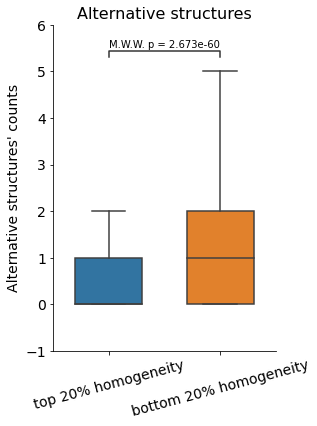

In [26]:
diff = df['altstruc'].quantile(q=0.99)
print(diff)
diff = df['altstruc'].quantile(q=0.99)
flt = df[df['altstruc'] >= diff]
flt['type'] = 'hub'
noflt = df[df['altstruc'] < diff]
noflt['type'] = 'nohub'
print(noflt.shape)
print(flt.shape)

df = pd.concat([noflt,flt]) 


def add_close_pos(row):
    center_pos = list(range(300,29550,10))
    close = min(center_pos, key=lambda x:abs(x-row.coord))
    return close

df['close'] = df.apply(add_close_pos, axis=1)

center_pos = list(range(300,29550,10))
list_homogeneity

### df
dict2 = {'close': center_pos, 'homogeneity': list_homogeneity} 
df2 = pd.DataFrame(dict2) 

df_all = pd.merge(df,df2,how='outer', on=['close','close'])
df_all['type'].value_counts()

df_all 
dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/'
df_all.to_csv(dir+'alter_homo_cov2000.txt',sep='\t') 


top_cut = df_all['homogeneity_x'].quantile(q=0.80)
bottom_cut = df_all['homogeneity_x'].quantile(q=0.20)
top = df_all[df_all['homogeneity_x'] >= top_cut]
bottom = df_all[df_all['homogeneity_x'] <= bottom_cut]
top['typehomo'] = "top 20% homogeneity"
bottom['typehomo'] = "bottom 20% homogeneity"
dplot = pd.concat([top,bottom]) 


### B. plots

plt.figure(figsize = (4,6))
order = ["top 20% homogeneity","bottom 20% homogeneity"]
g = sns.boxplot(data=dplot, x="typehomo", y="altstruc", order=order, showfliers = False, dodge = False, width = 0.6) #order = order, #showfliers = False,   #palette = my_pal, , width = 1
plt.title('Alternative structures',fontsize = 16)
plt.xlabel('',fontsize = 14) 
plt.ylabel("Alternative structures' counts",fontsize = 14)
plt.xticks(fontsize = 14,rotation=15) 
plt.yticks(fontsize = 14) 
plt.ylim(-1,6)

g.spines[['right', 'top']].set_visible(False)
    
add_stat_annotation(g, data=dplot, x="typehomo", y="altstruc",  order=order, 
                        box_pairs = [("top 20% homogeneity","bottom 20% homogeneity")
                                    ],
                        test="Mann-Whitney", text_format='full', loc='outside', line_offset_to_box=-0.1, verbose=3)

dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig6/Data/'
plt.savefig(dir_out+'Supp_Figure_6b_homogeneiety_vs_alterstructure.pdf',bbox_inches='tight', dpi=300) 